In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [3]:
numerical_cols = ['tenure','MonthlyCharges','TotalCharges']

In [4]:
# Missing values in total charges
print(f"Missing values in total charges:\n{data['TotalCharges'].isnull().sum()}")

Missing values in total charges:
11


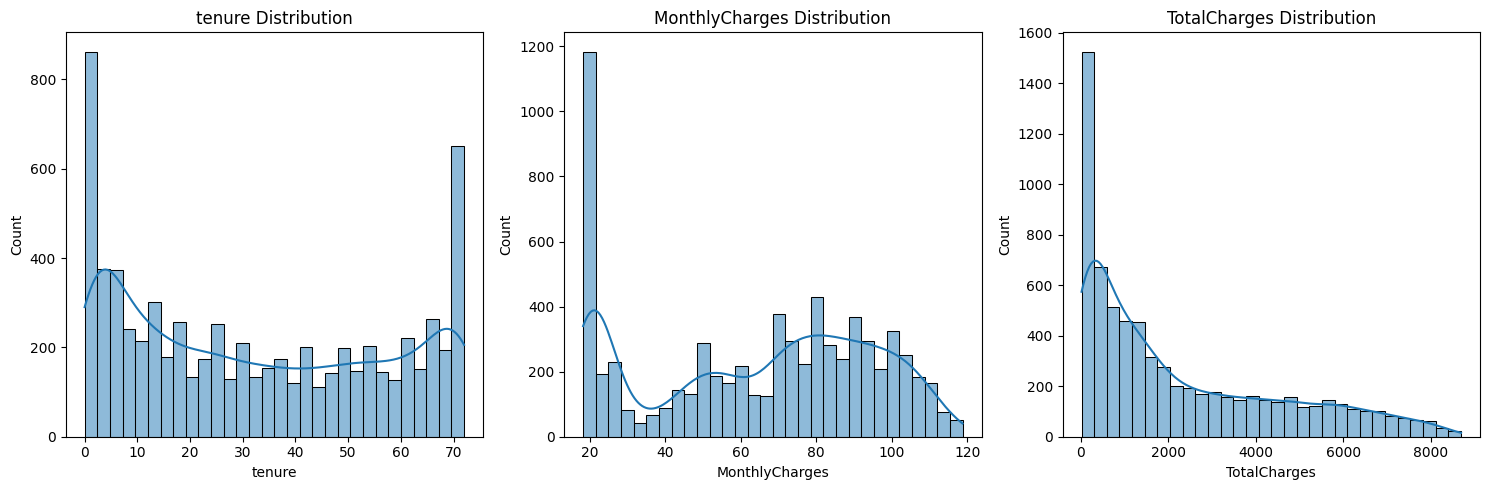

In [5]:
plt.figure(figsize=(15,5))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1,3,i)
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f"{col} Distribution")

plt.tight_layout()
plt.show()

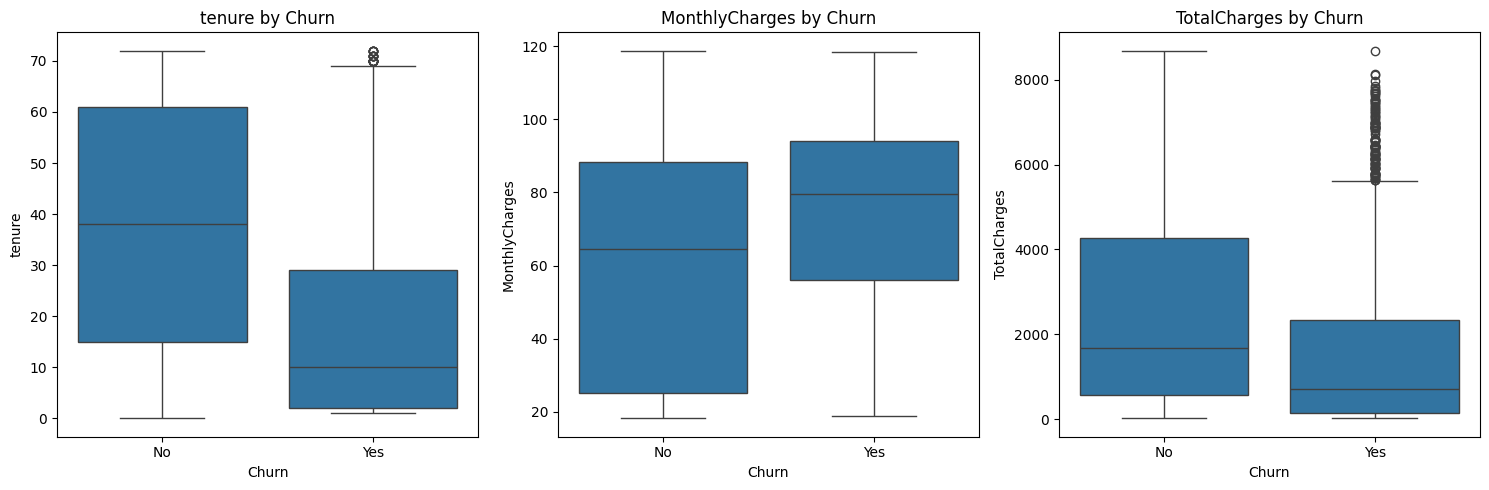

In [6]:
plt.figure(figsize=(15,5))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1,3,i)
    sns.boxplot(x='Churn', y=col, data=data)
    plt.title(f"{col} by Churn")
plt.tight_layout()
plt.show()
    

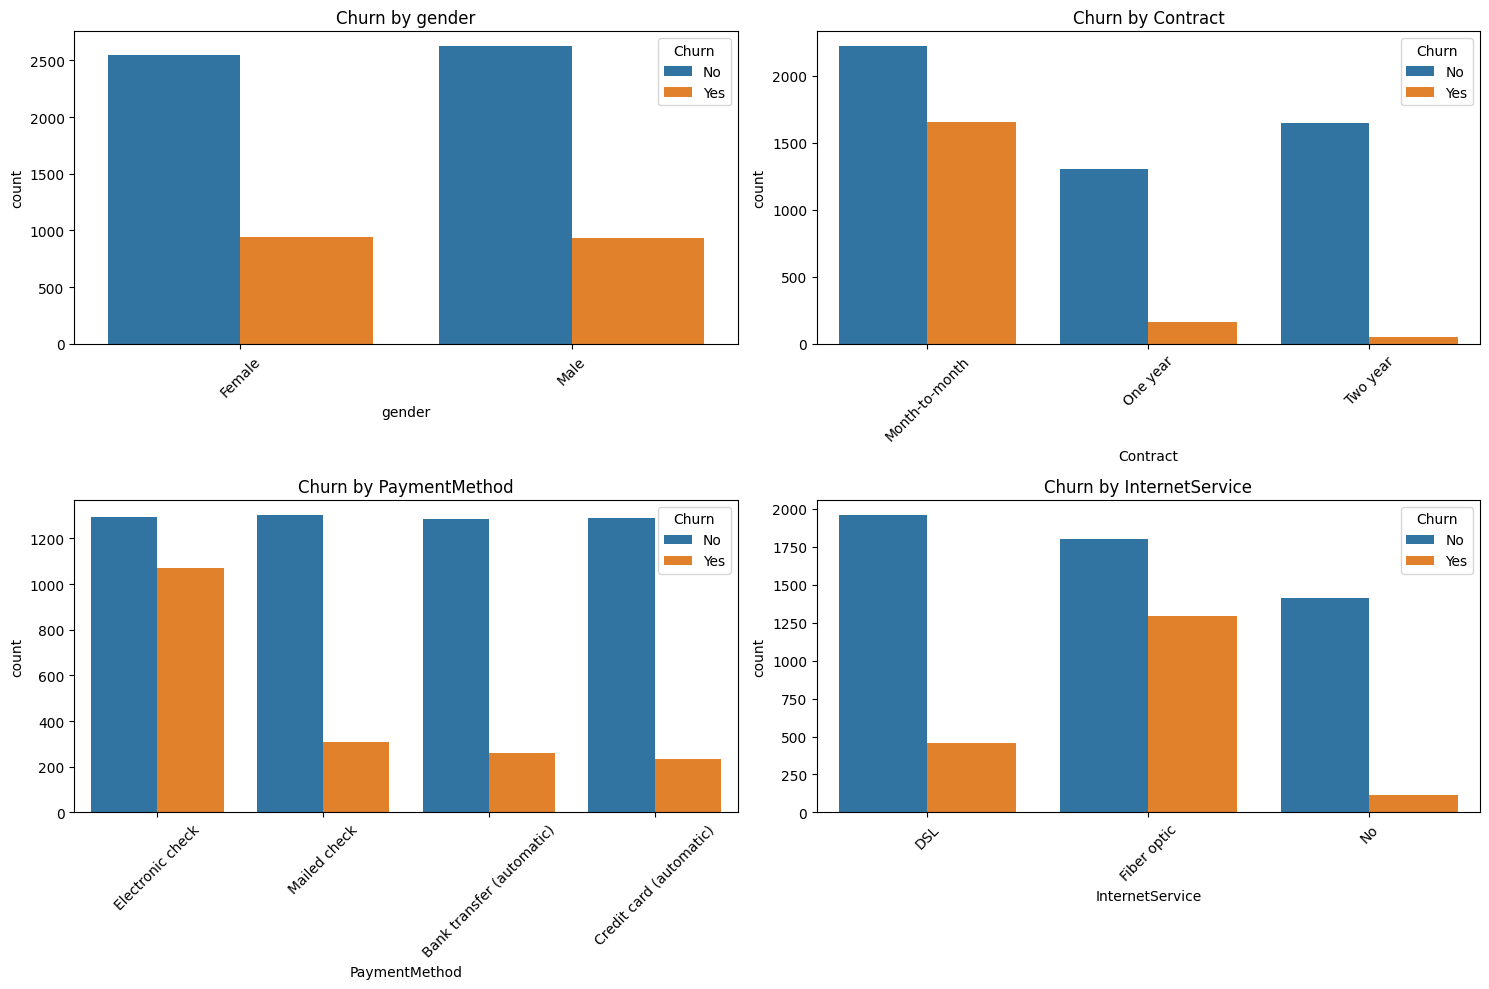

In [7]:
# Categorical features: Bar plots
catagorical_cols = ['gender','Contract','PaymentMethod','InternetService']
plt.figure(figsize=(15,10))
for i, col in enumerate(catagorical_cols, 1):
    plt.subplot(2,2,i)
    sns.countplot(x=col, hue='Churn', data=data)
    plt.title(f"Churn by {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


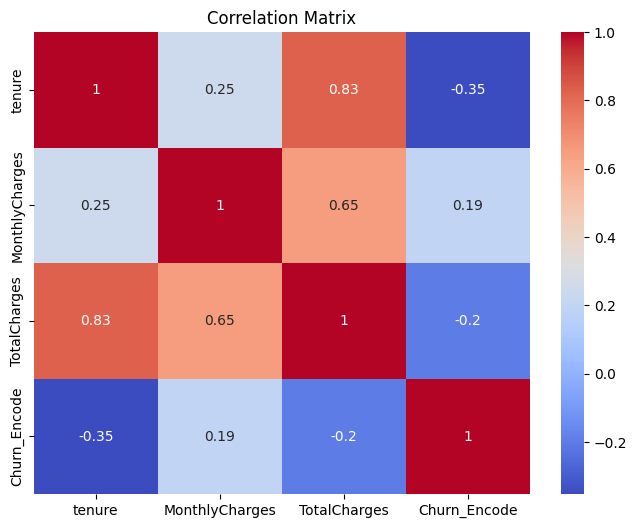

Correlation with Churn
 tenure           -0.352229
MonthlyCharges    0.193356
TotalCharges     -0.199484
Churn_Encode      1.000000
Name: Churn_Encode, dtype: float64


In [8]:
data['Churn_Encode'] = data['Churn'].map({'Yes':1, 'No':0})
correlation = data[numerical_cols + ['Churn_Encode']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()
print("Correlation with Churn\n", correlation['Churn_Encode'])

In [9]:
items = data[(data['tenure'] <40) & (data['Contract'] == 'Month-to-month')]

In [10]:
items

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Encode
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes,1
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7032,6894-LFHLY,Male,1,No,No,1,Yes,Yes,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,75.75,75.75,Yes,1
7033,9767-FFLEM,Male,0,No,No,38,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Credit card (automatic),69.50,2625.25,No,0
7035,8456-QDAVC,Male,0,No,No,19,Yes,No,Fiber optic,No,...,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),78.70,1495.10,No,0
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,0


In [11]:
nonchurn = (data['Churn_Encode'] == 1).sum()
churn = (data['Churn_Encode'] == 0).sum()

In [12]:
print(f"Numbre of churners with less than 40 tanure and Month to month contract, {churn}")
print(f"Numbre of not-churners with less than 40 tanure and Month to month contract, {nonchurn}")

Numbre of churners with less than 40 tanure and Month to month contract, 5174
Numbre of not-churners with less than 40 tanure and Month to month contract, 1869


In [13]:
payment_methods = data['PaymentMethod'].unique()
print(payment_methods)

['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [14]:
churners = ((data['PaymentMethod'] == payment_methods[0]) & (data['Churn_Encode'] == 1)).sum()
non_churners = ((data['PaymentMethod']== payment_methods[0]) & (data['Churn_Encode']== 0)).sum()

churners1 = ((data['PaymentMethod'] == payment_methods[1]) & (data['Churn_Encode'] == 1)).sum()
non_churners1 = ((data['PaymentMethod']== payment_methods[1]) & (data['Churn_Encode']== 0)).sum()

churners2 = ((data['PaymentMethod'] == payment_methods[2]) & (data['Churn_Encode'] == 1)).sum()
non_churners2 = ((data['PaymentMethod']== payment_methods[2]) & (data['Churn_Encode']== 0)).sum()

churners3 = ((data['PaymentMethod'] == payment_methods[3]) & (data['Churn_Encode'] == 1)).sum()
non_churners3 = ((data['PaymentMethod']== payment_methods[3]) & (data['Churn_Encode']== 0)).sum()

In [15]:
print(f"churners with payment method '{payment_methods[0]}': {churners}")
print(f"Non-Churners with payment method '{payment_methods[0]}': {non_churners}")

print(f"churners with payment method '{payment_methods[1]}': {churners1}")
print(f"Non-Churners with payment method '{payment_methods[1]}': {non_churners1}")

print(f"churners with payment method '{payment_methods[2]}': {churners2}")
print(f"Non-Churners with payment method '{payment_methods[2]}': {non_churners2}")

print(f"churners with payment method '{payment_methods[3]}': {churners3}")
print(f"Non-Churners with payment method '{payment_methods[3]}': {non_churners3}")

churners with payment method 'Electronic check': 1071
Non-Churners with payment method 'Electronic check': 1294
churners with payment method 'Mailed check': 308
Non-Churners with payment method 'Mailed check': 1304
churners with payment method 'Bank transfer (automatic)': 258
Non-Churners with payment method 'Bank transfer (automatic)': 1286
churners with payment method 'Credit card (automatic)': 232
Non-Churners with payment method 'Credit card (automatic)': 1290


In [16]:
# Load dataset
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [17]:
X = data.drop(['customerID', 'Churn'], axis=1)
y = data['Churn'].map({'Yes':1, 'No':0})

In [33]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ]
)

In [34]:
# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [35]:
# Train Model
log_reg = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [36]:
# Evaluate Models
models = {"Logistic Regression": log_reg, "Random Forest": rf}
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name} performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred):.4f}")


Logistic Regression performance:
Accuracy: 0.8211
Precision: 0.6862
Recall: 0.5979
ROC-AUC: 0.7497

Random Forest performance:
Accuracy: 0.7878
Precision: 0.6370
Recall: 0.4611
ROC-AUC: 0.6833


In [37]:
# Save RandomForest Model
joblib.dump(rf,'churn_model.pkl')
joblib.dump(preprocessor, "Preprocessor.pkl")

['Preprocessor.pkl']

In [23]:
# Feature importance for Random Forest
feature_names = numerical_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
importances = rf.feature_importances_
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("\nRandom Forest Feature Importance (Top 10):")
print(feature_importance.head(10))


Random Forest Feature Importance (Top 10):
TotalCharges                      0.195520
tenure                            0.173909
MonthlyCharges                    0.173030
InternetService_Fiber optic       0.037988
PaymentMethod_Electronic check    0.035654
gender_Male                       0.027808
Contract_Two year                 0.026929
OnlineSecurity_Yes                0.026529
PaperlessBilling_Yes              0.025781
Partner_Yes                       0.024144
dtype: float64


In [24]:
print(f"X train shape: {X_train.shape}\nX test shape: {X_test.shape}")

X train shape: (5634, 30)
X test shape: (1409, 30)


C:\Users\KHURSHEED AHMED\AppData\Local\Temp\ipykernel_12056\40212470.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


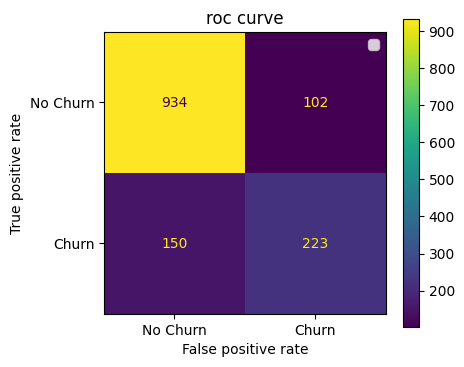

C:\Users\KHURSHEED AHMED\AppData\Local\Temp\ipykernel_12056\40212470.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


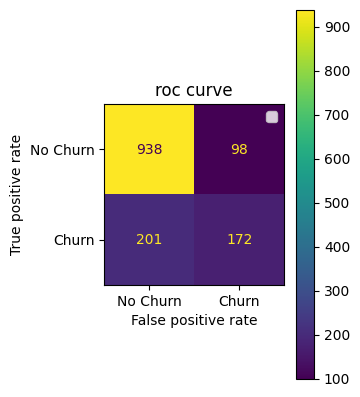

In [29]:
plt.figure(figsize=(10, 4))
for i, (name, model) in enumerate({"Logistic Regression":log_reg, "Random Forest":rf}.items(), 1):
    plt.subplot(1,2,i)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["No Churn", "Churn"]).plot(ax=plt.gca())
    plt.title(f"{name} Confussion Matrix")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("roc curve")
    plt.legend()
    plt.show()

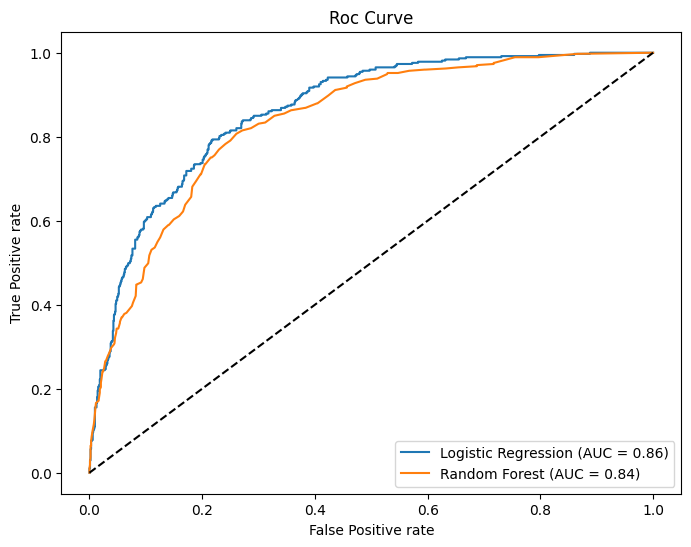

In [32]:
plt.figure(figsize=(8,6))
for name, model in {"Logistic Regression": log_reg,"Random Forest": rf}.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1],[0, 1], 'k--')
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("Roc Curve")
plt.legend()
plt.show()
